In [318]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
from torch import Tensor
from datetime import datetime
import math
import random
from mynn import *
import numpy as NP
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [319]:
initLogging()

dtype = torch.float

log("dtype", dtype)

dvc = torch.device("cpu")

log("device", dvc.type)

rndSeed = 42
log("rndSeed", rndSeed)

trRatio = 0.8
log("trRatio", trRatio)

devRatio = 0.9
log("devRatio", devRatio)

contextSize = 3
log("contextSize", contextSize)

embeddingDims = 10
log("embeddingDims", embeddingDims)

hiddenLayerSize = 200
log("hiddenLayerSize", hiddenLayerSize)

trainingBatchSize = 32
log("trainingBatchSize", trainingBatchSize)

rndSeed2 = 2147483647
log("rndSeed2", rndSeed2)

g = torch.Generator(device=dvc).manual_seed(rndSeed2)
gSampling = torch.Generator(device=dvc).manual_seed(rndSeed2 + 10)

words = readFileSplitByLine("names.txt")
random.seed(rndSeed)
random.shuffle(words)
log("first few words", words[:5])

lenWords = len(words);
log("lenWords", lenWords)

allPossibleChars = sorted(list(set("".join(words))))
log("allPossibleChars", allPossibleChars)

stoi = sToI(allPossibleChars)
log("stoi", stoi)

itos = iToS(stoi)
log("itos", itos)

vocabularyLength = len(itos)
log("vocabularyLength", vocabularyLength)

lenTrain = int(trRatio * lenWords)
trWords = words[:lenTrain]
trX, trY = buildDataSet(trWords, contextSize, stoi, itos, dvc)
log("data set training", lenTrain, trX.shape, trY.shape, trWords[:3])

endDev = int(devRatio * lenWords)
devWords = words[lenTrain:endDev];
devX, devY = buildDataSet(devWords, contextSize, stoi, itos, dvc)
log("data set dev", endDev - lenTrain, devX.shape, devY.shape, devWords[:3])

lenTest = lenWords - endDev
tstWords = words[endDev:]
tstX, tstY = buildDataSet(tstWords, contextSize, stoi, itos, dvc)
log("data set test", lenTest, tstX.shape, tstY.shape, tstWords[:3])

np = makeNetwork(g, vocabularyLength, embeddingDims, contextSize, hiddenLayerSize, dvc)
log("parametersCount", sum(p.nelement() for p in np.all))

log("random probability", f"{-torch.tensor(1 / vocabularyLength).log().item():.4f}")

@torch.no_grad()
def trLoss(): return getLoss(np, np.C[trX], trY)

@torch.no_grad()
def devLoss(): return getLoss(np, np.C[devX], devY)

@torch.no_grad()
def tstLoss(): return getLoss(np, np.C[tstX], tstY)

class Losses:
    tr: Loss
    dev: Loss
    tst: Loss

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.dev = devLoss()
    l.tst = tstLoss()
    return l

def logLosses():
    losses = getLosses()
    l1 = f"{losses.tr.loss.item():>10.4f}"
    l2 = f"{losses.dev.loss.item():>10.4f}"
    l3 = f"{losses.tst.loss.item():>10.4f}"
    log(f"{l1} {l2} {l3}")

trXLength = trX.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
log ("trainingSteps: ", trainingSteps)

lr = 0.1;
lre = torch.linspace(-3, 0, trainingSteps)
lrs = 10 ** lre
lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
fr = ForwardPassResult()
fr.loss = torch.tensor(0)
up = UpdateNetResult()

2023-07-06 15:16:01  ==========================================:
dtype:               torch.float32
device:              cpu
rndSeed:             42
trRatio:             0.8
devRatio:            0.9
contextSize:         3
embeddingDims:       10
hiddenLayerSize:     200
trainingBatchSize:   32
rndSeed2:            2147483647
first few words:     ['yuheng', 'diondre', 'xavien', 'jori', 'juanluis']
lenWords:            32033
allPossibleChars:    ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:                {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos:                {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 

In [320]:
logSection("Learning")

maxIteration = 1
log("maxIteration",maxIteration)

repeats = 36
log("repeats",repeats)

maxLr = 0.14
log("maxLr", maxLr)

minLr = 0.0001
log("minLr", minLr)

actualIterations = min(maxIteration, repeats * math.ceil(trXLength / trainingBatchSize))
log("actualIterations", actualIterations)

i = 0
for repeat in range(repeats):
    
    log(f"{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ", end="")
    logLosses()

    for start in range(0, trXLength, trainingBatchSize):

        if i >= maxIteration:
            log("break")
            break;
        
        end = min(start + trainingBatchSize, trXLength)
        #miniBatchIxs = torch.arange(start, end)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, trX, trY, miniBatchIxs)
        
        backwardPass(np.all, fr.loss)

        if i == 1:
            plt.figure(figsize=(20,10))
            plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")
        
        up = updateNet(np.all, i, actualIterations, maxLr, minLr)
        lrAtIx.append(up.learningRate)

        stepIx.append(i)
        lossAtIx.append(fr.loss.item())
        logLossAtIx.append(fr.loss.log10().item())

        #lr = lrs[i].item()
        #lrAtIx.append(lrs[i].item())

        #if repeat == 0 and i % (trainingBatchSize * 10) == 0:
        #    log(f"{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ")

        #if i % 10_000 == 0:
        #    log(f"{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ")
        
        i += 1

logLosses()

#bestLr = lrs[findLowestIndex(lossAtIx)].item();
#log("best learning rate", bestLr)
log("emb.shape", fr.emb.shape)
log("h.shape", fr.h.shape)
log("logits.shape", fr.logits.shape)

Learning:            -------------------------- 2023-07-06_15_16_03
maxIteration:        1
repeats:             36
maxLr:               0.14
minLr:               0.0001
actualIterations:    1
  0,      0 losses:     0.0000   :    3.3058     3.3057     3.3058:
break:              
  1,      1 losses:     3.3135   :    3.2192     3.2194     3.2186:
break:              
  2,      1 losses:     3.3135   :    3.2192     3.2194     3.2186:
break:              
  3,      1 losses:     3.3135   :    3.2192     3.2194     3.2186:
break:              
  4,      1 losses:     3.3135   :    3.2192     3.2194     3.2186:
break:              
  5,      1 losses:     3.3135   :    3.2192     3.2194     3.2186:
break:              
  6,      1 losses:     3.3135   :    3.2192     3.2194     3.2186:
break:              
  7,      1 losses:     3.3135   :    3.2192     3.2194     3.2186:
break:              
  8,      1 losses:     3.3135   :    3.2192     3.2194     3.2186:
break:              
  9,   

C:\Users\m.minich\AppData\Local\Temp\ipykernel_22280\2748416694.py:2: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(min(lrAtIx), max(lrAtIx))


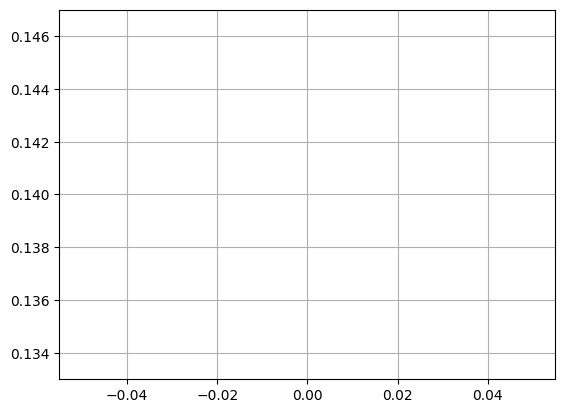

Actual min max LR 0.14 0.14


In [321]:
plt.plot(range(len(lrAtIx)), lrAtIx, "black")
plt.ylim(min(lrAtIx), max(lrAtIx))
plt.grid(True)
plt.show()
print("Actual min max LR", max(lrAtIx), min(lrAtIx))

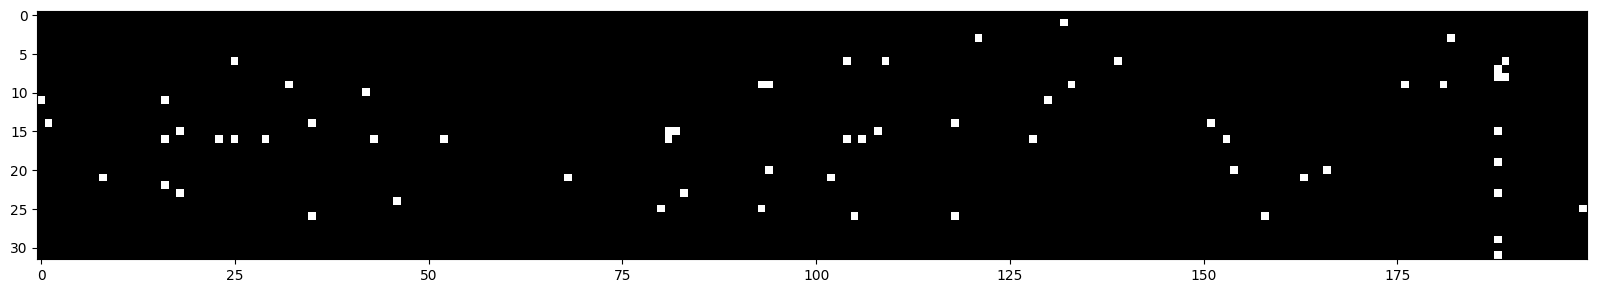

In [322]:
plt.figure(figsize=(20,10))
plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")

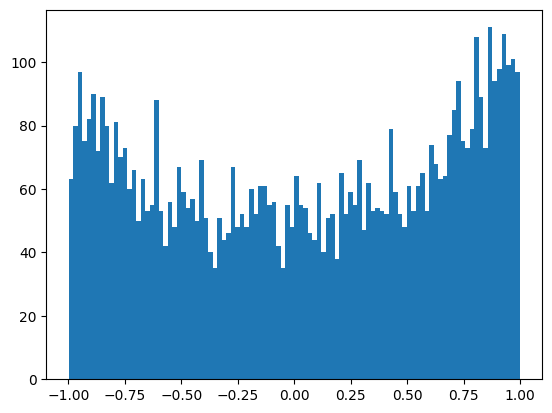

In [323]:
plt.hist(fr.h.view(-1).tolist(), 100);

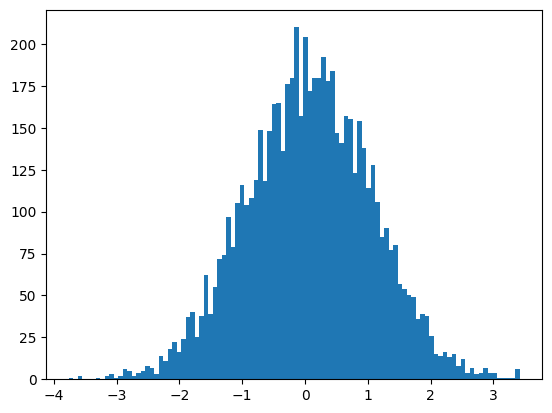

In [324]:
plt.hist(fr.hPreActivations.view(-1).tolist(), 100);

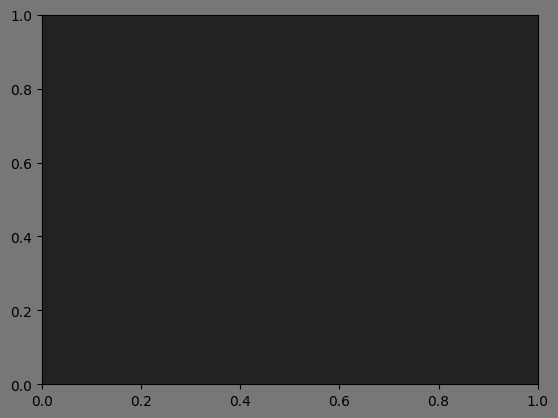

In [325]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
#ax.plot(lrAtIx, lossAtIx)
plt.show()

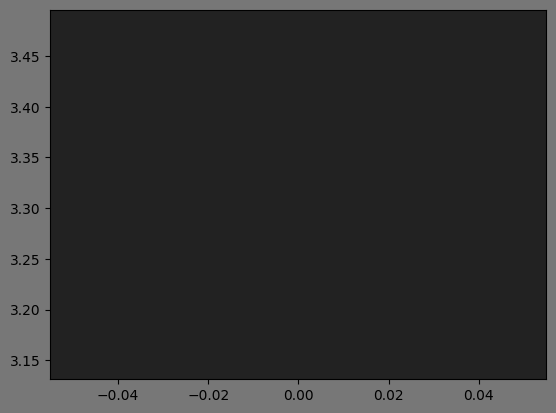

In [326]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, lossAtIx)
plt.show()

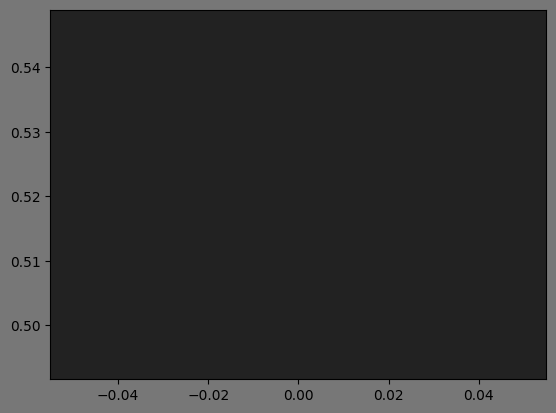

In [327]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, logLossAtIx)
plt.show()

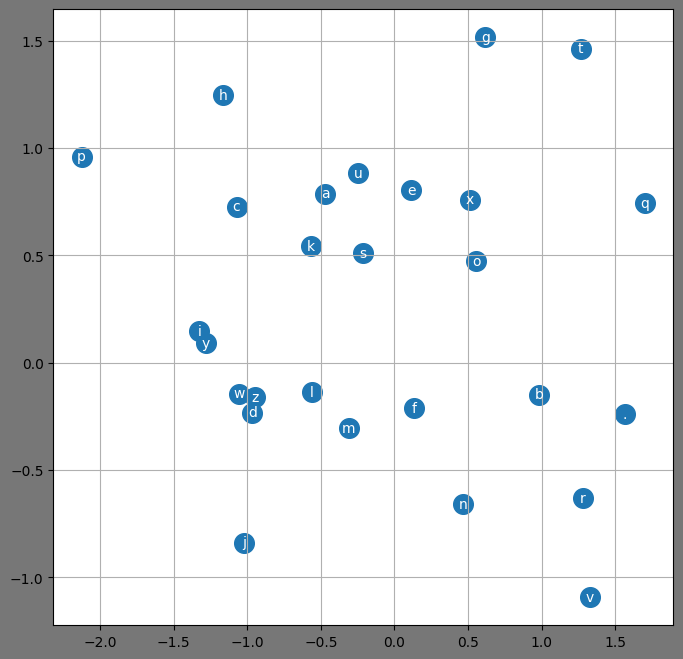

In [328]:
dim = 0
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("#777777")
sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
for i in range(np.C.shape[0]):
    plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [333]:
logSection("Sampling")

samples = sample(np, gSampling, contextSize, itos, 20)
for s in samples:
    logSimple("".join(s.values) + "  ", end="")
    for p in [s.prob] + s.probs:
        logSimple(f"{(p * 100):.0f} ", end="")
    logSimple()

Sampling:            -------------------------- 2023-07-06_15_16_41
ascnpc.  11 108 96 95 103 103 98 76 
cilwtanczhnd.  7 97 104 80 88 99 94 110 97 104 98 97 103 137 
ebimm.  21 103 118 107 87 93 122 
ynwfluzjaghwehtvggujbklwvofjiuzx.  1 86 95 85 102 111 124 103 101 94 99 89 93 103 78 106 90 104 95 106 93 95 94 116 81 106 91 107 86 98 100 92 95 129 
zufhraijjuuy.  10 88 125 98 97 97 110 93 98 100 92 92 102 142 
t.  58 80 145 
ccliuisjzfxvotxomeorie.  15 97 104 80 99 116 115 100 107 98 116 96 106 103 118 108 102 91 118 98 118 96 104 158 
qqjkzdvawyifgqlsmuomvvnegbgdiyhtwt.  2 97 103 87 98 79 100 105 89 89 91 100 97 99 89 115 100 93 110 89 92 97 87 106 103 104 99 104 110 110 96 97 90 90 97 158 
jwfvcgdv.  12 87 87 106 121 101 105 105 88 115 
beejsxrsy.  13 129 105 90 105 96 102 101 87 113 105 
nabhxtnxeardpqyjmxsq.  2 93 115 80 79 98 111 94 111 109 96 110 97 87 87 102 109 92 96 85 94 72 
jkobetcfmsncovpepyckoajkdgvoyelrpfpayamrtkchqpjplbjztuqqcjteuesulsjivxawfahvyevktorgdxltd.  2 87 104 

In [330]:
ps = calcProb(np, "mel.", contextSize, stoi)
op = calcOneProb(ps)
for p in [op] + ps:
    logSimple(f"{(p * 100):.0f} ", end="")

30 82 110 100 133 

In [331]:
np.C.shape, trX.shape, np.C[trX].shape, np.C[:5], trX[:5], np.C[trX][:5]

(torch.Size([27, 10]),
 torch.Size([182625, 3]),
 torch.Size([182625, 3, 10]),
 tensor([[ 1.5675, -0.2380, -0.0274, -1.1011,  0.2853, -0.0305, -1.5467,  0.6048,
           0.0794,  0.9046],
         [-0.4711,  0.7871, -0.3283, -0.4330,  1.3727,  2.9331,  1.5619, -1.6261,
           0.6771, -0.8406],
         [ 0.9850, -0.1483, -1.4794,  0.4483, -0.0707,  2.4969,  2.4448, -0.6701,
          -1.2198,  0.3032],
         [-1.0726,  0.7276,  0.0511,  1.3096, -0.8021, -0.8503, -1.8068,  1.2522,
          -1.2256,  1.2165],
         [-0.9648, -0.2321, -0.3477,  0.3324, -1.3264,  1.1223,  0.5963,  0.4585,
           0.0541, -1.7400]], grad_fn=<SliceBackward0>),
 tensor([[ 0,  0,  0],
         [ 0,  0, 25],
         [ 0, 25, 21],
         [25, 21,  8],
         [21,  8,  5]]),
 tensor([[[ 1.5675, -0.2380, -0.0274, -1.1011,  0.2853, -0.0305, -1.5467,
            0.6048,  0.0794,  0.9046],
          [ 1.5675, -0.2380, -0.0274, -1.1011,  0.2853, -0.0305, -1.5467,
            0.6048,  0.0794,  0.90

In [332]:
import torch
import math# this ensures that the current MacOS version is at least 12.3+
log(torch.backends.mps.is_available())# this ensures that the current current PyTorch installation was built with MPS activated.
log(torch.backends.mps.is_built())

TypeError: unsupported operand type(s) for +: 'bool' and 'str'

In [ ]:
# Let"s suppose these are your lists
C = [
[ 0.8774, -0.6801],
         [ 0.1651, -0.5025],
         [ 0.2769, -0.3570],
         [-0.8820,  0.3902],
         [-0.4824,  0.8744],
         [-0.3190,  0.7807],
         [-0.0100, -0.3401],
         [ 0.9975,  2.8280],
         [ 0.9623, -1.3172],
         [ 0.2180, -0.3820],
         [ 0.6139, -0.4287],
         [-0.7386,  0.5880],
         [-0.3088,  0.9816],
         [ 0.3907, -0.4174],
         [-0.7380,  0.5205],
         [-0.5288,  0.7074],
         [-0.3956,  0.9625],
         [-0.3802, -0.3504],
         [-0.2861,  0.7589],
         [ 0.5309, -0.5105],
         [-0.0922, -0.6410],
         [-0.3823,  0.9899],
         [ 0.0965, -0.5708],
         [-0.8582, -1.3429],
         [-0.4960,  0.2842],
         [-0.6105,  0.1336],
         [-0.2623,  0.2942]
]
trX = [
    [0, 0, 0],
    [0, 0, 22],
    [0, 22, 9],
    [22, 9, 15],
    [9, 15, 12],
    # ... More values
]

# We create a new list to hold the result
result = []

# We loop over each element in trX
for i in range(len(trX)):
    temp = []
    # Then we loop over each value in the element
    for j in range(len(trX[i])):
        # We use the value as an index to get the corresponding data from C
        temp.append(C[trX[i][j]])
    # We add the result to our new list
    result.append(temp)

# Let"s log the first 5 elements of the result list
for i in range(5):
    print(result[i])

[[0.8774, -0.6801], [0.8774, -0.6801], [0.8774, -0.6801]]
[[0.8774, -0.6801], [0.8774, -0.6801], [0.0965, -0.5708]]
[[0.8774, -0.6801], [0.0965, -0.5708], [0.218, -0.382]]
[[0.0965, -0.5708], [0.218, -0.382], [-0.5288, 0.7074]]
[[0.218, -0.382], [-0.5288, 0.7074], [-0.3088, 0.9816]]
